In [2]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import json
from shapely import wkb
print(os.getcwd())

from neo4j import GraphDatabase
import psycopg2
from shapely.geometry import Point

import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


/home/jovyan/work/Group-4/business-opportunity-graph/notebooks


In [7]:
#from gemini

def get_degrees(tx, node_label: str = None, rel_type: str = None) -> dict[int, int]:
    # Construct the node pattern: (n) if node_label is None/empty, or (n:Label) otherwise
    node_pattern = f"(n{f':{node_label}' if node_label else ''})"

    # Construct the relationship pattern: -[]- if rel_type is None/empty, or -[:TYPE]- otherwise
    rel_pattern = f"-[r{f':{rel_type}' if rel_type else ''}]-"

    query = f"""
    MATCH {node_pattern}{rel_pattern}()
    RETURN elementId(n) as id, count(r) as degree
    """
    
    result = tx.run(query)
    # The result.data() method returns a list of dictionaries, 
    # e.g., [{'id': '4:0', 'degree': 5}, {'id': '4:1', 'degree': 3}]
    res = result.data()
    return res

In [3]:
#functions from Graph Data Science with Neo4J by Estelle Scifo
# def get_degrees(tx, node_label: str, rel_type: str) -> dict[int, int]:
#     query = f"""
#     MATCH (n:{node_label})-[r:{rel_type}]-() 
#     RETURN elementId(n) as id, count(r) as degree
#     """
#     result = tx.run(query)
#     res = result.data()
#     return res



def plot_degree_distribution(degrees: pd.Series):
    # define figure and subplots
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.subplots(1, 1)

    # compute and draw degree distribution
    distribution = degrees.value_counts().sort_index()
    distribution.plot(
        ax=ax1, 
        marker="o", color="k",
        title="Degree Distribution", xlabel="Degree", ylabel="nbOccurrences",
        logy=True, 
        logx=True,
    )

    fig.tight_layout()
    return fig



In [4]:
SD_crs = 'EPSG:26946'
common_crs = "EPSG:4326"


data_path = '../data/'



In [5]:
# Setup remote group neo4j instance with the following credentials
# This is the database we will write to and use in our project
group_driver = GraphDatabase.driver(
     "bolt://67.58.49.87:7687",
     auth=("neo4j", "h2u9l4px")
)


# group_driver = GraphDatabase.driver(
#      os.getenv("NEO4J_URI_GROUP"),
#      auth=(os.getenv("NEO4J_USER_GROUP"), os.getenv("NEO4J_PASSWORD_GROUP"))
# )
with group_driver.session() as session:
    result = session.run("MATCH (n) UNWIND labels(n) AS label RETURN count(DISTINCT label) AS count")
    num_nodes = result.single()["count"]
    print(f"Connection Successful: {num_nodes} unique node types found in the graph database")

Connection Successful: 10 unique node types found in the graph database


[{'id': '4:f138a071-9a96-444f-b874-ea6c62582d80:33186', 'degree': 3}, {'id': '4:f138a071-9a96-444f-b874-ea6c62582d80:73876', 'degree': 15}, {'id': '4:f138a071-9a96-444f-b874-ea6c62582d80:33187', 'degree': 2}]


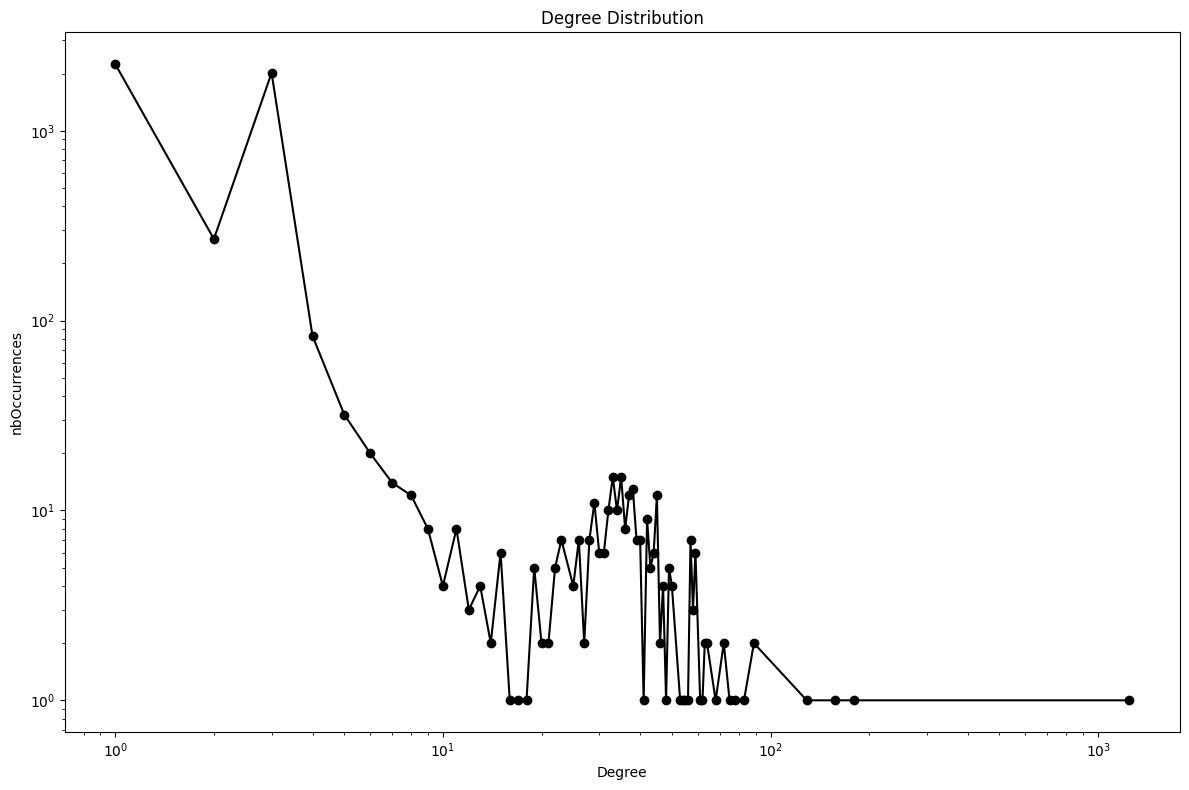

In [8]:
with group_driver.session() as s:
    # degree_data = s.read_transaction(get_degrees, "Person", "KNOWS")
    # degree_data = s.execute_read(get_degrees, "BusinessLocation", "contained_in")
    degree_data = s.execute_read(get_degrees)    
print(degree_data[:3])


data = pd.DataFrame(degree_data)

plot_degree_distribution(data.degree);

In [74]:
# Geodataframes

In [14]:

boundaries_zip = 'City_and_County_Boundaries.zip'
boundaries_path = os.path.join(data_path, boundaries_zip)
boundaries_gdf = gpd.read_file(boundaries_path)



communities_csv = 'sd_community_boundaries.csv'
communities_path = os.path.join(data_path, communities_csv)
communities = gpd.read_file(communities_path)
communities_gdf = gpd.GeoDataFrame(
    geometry=gpd.GeoSeries.from_wkt(communities['geometry'], crs=common_crs), data=communities
)
communities_gdf = communities_gdf.rename(columns={'name': 'community'})



business_location_df = pd.read_json("../data/business_location.json")
business_location_geometry = [Point(xy) for xy in zip(business_location_df.longitude, business_location_df.latitude)]
business_location_gdf = gpd.GeoDataFrame(business_location_df, crs="EPSG:4326", geometry=business_location_geometry)
business_location_gdf = business_location_gdf[business_location_gdf['longitude']!=180] #fix these outliers


block_group_df = pd.read_json("../data/block_group.json")


In [15]:
boundaries_gdf = boundaries_gdf.to_crs(common_crs)
communities_gdf = communities_gdf.to_crs(common_crs)



In [16]:
sd_boundaries_gdf = boundaries_gdf[boundaries_gdf['COUNTY_NAM'] == 'San Diego']
sd_boundaries_mixed = sd_boundaries_gdf[['CITY','geometry']]

sd_cities_boundaries_gdf= sd_boundaries_mixed.rename(columns={"CITY": "City"}).dissolve(by= 'City').reset_index()


In [27]:
business_location_gdf[business_location_gdf['franchise']=="FRANCHISE"]

,id,name,url,address,city,zip,latitude,longitude,blockgroup,categories,avg_rating,franchise,confidence,reasoning,geom,geometry
1,24,Wetzel's Pretzels,https://www.google.com/maps/place//data=!4m2!3...,"Wetzel's Pretzels, 869 W. Harbor Drive, #C2-F,...",San Diego,92101,32.708565,-117.170277,54023.0,[Pretzel store],3.9,FRANCHISE,0.95,Wetzel's Pretzels is a well-known chain specia...,0101000020E6100000DD0F2ED3E54A5DC0B68AB443B25A...,POINT (-117.17028 32.70857)
3,49,Brainy Actz Escape Rooms San Diego,https://www.google.com/maps/place//data=!4m2!3...,"Brainy Actz Escape Rooms San Diego, 10211 Paci...",San Diego,92121,32.903380,-117.190299,83462.0,"[Escape room center, Children's amusement cent...",4.3,FRANCHISE,0.85,The name 'Brainy Actz Escape Rooms' suggests a...,0101000020E6100000BEFD6FDB2D4C5DC08F2EDBF3A173...,POINT (-117.1903 32.90338)
4,50,Einstein Bros. Bagels,https://www.google.com/maps/place//data=!4m2!3...,"Einstein Bros. Bagels, 911 Lomas Santa Fe Dr, ...",Solana Beach,92075,32.994224,-117.255235,173061.0,"[Bagel shop, Bakery, Breakfast restaurant, Caf...",3.9,FRANCHISE,0.95,Einstein Bros. Bagels is a well-known chain wi...,0101000020E61000007A53ECC355505DC0BAB1EABD427F...,POINT (-117.25523 32.99422)
14,253,Subway,https://www.google.com/maps/place//data=!4m2!3...,"Subway, 1915 El Cajon Blvd, San Diego, CA 92104",San Diego,92104,32.754837,-117.144664,9023.0,"[Sandwich shop, Caterer, Fast food restaurant,...",4.2,FRANCHISE,1.00,Subway is a well-known franchise brand recogni...,0101000020E610000084590D2E42495DC0F0E65F819E60...,POINT (-117.14466 32.75484)
16,289,Chevron,https://www.google.com/maps/place//data=!4m2!3...,"Chevron, 604 Dennery Rd, San Diego, CA 92154",San Diego,92154,32.583267,-117.032714,100172.0,"[Gas station, Auto repair shop, Convenience st...",2.6,FRANCHISE,0.90,Chevron is a well-known brand and operates as ...,0101000020E6100000C40776FC17425DC003EB387EA84A...,POINT (-117.03271 32.58327)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39552,515688,Banfield Pet Hospital,https://www.google.com/maps/place//data=!4m2!3...,"Banfield Pet Hospital, 700 Centre City Parkway...",Escondido,92025,33.127724,-117.090744,202141.0,"[Veterinarian, Animal hospital]",4.4,FRANCHISE,0.90,Banfield Pet Hospital is a well-known chain of...,0101000020E6100000BA13ECBFCE455DC0B476363F5990...,POINT (-117.09074 33.12772)
39564,515842,Big Lots,https://www.google.com/maps/place//data=!4m2!3...,"Big Lots, 9340 Mira Mesa Blvd, San Diego, CA 9...",San Diego,92126,32.918290,-117.123564,83552.0,"[Discount store, Furniture store, Grocery store]",4.3,FRANCHISE,0.95,Big Lots is a well-known retail chain that ope...,0101000020E6100000357DD179E8475DC0891D328A8A75...,POINT (-117.12356 32.91829)
39566,515860,Domino's Pizza,https://www.google.com/maps/place//data=!4m2!3...,"Domino's Pizza, 1332 Main St, Ramona, CA 92065",Ramona,92065,33.038174,-116.873987,208064.0,"[Pizza delivery, Delivery Restaurant, Takeout ...",4.2,FRANCHISE,1.00,Domino's Pizza is a well-known franchise brand...,0101000020E61000006D07D968EF375DC009C95DDFE284...,POINT (-116.87399 33.03817)
39568,515940,Albertsons,https://www.google.com/maps/place//data=!4m2!3...,"Albertsons, 1601 S Melrose Dr, Vista, CA 92081",Vista,92081,33.166625,-117.247901,198101.0,"[Grocery store, Grocery delivery service]",4.2,FRANCHISE,0.90,Albertsons is a well-known grocery store chain...,0101000020E6100000296A7A9ADD4F5DC0589A4AF55395...,POINT (-117.2479 33.16662)


/tmp/ipykernel_320/1056537142.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(communities_gdf.geometry.centroid.x,
/tmp/ipykernel_320/1056537142.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  communities_gdf.geometry.centroid.y,


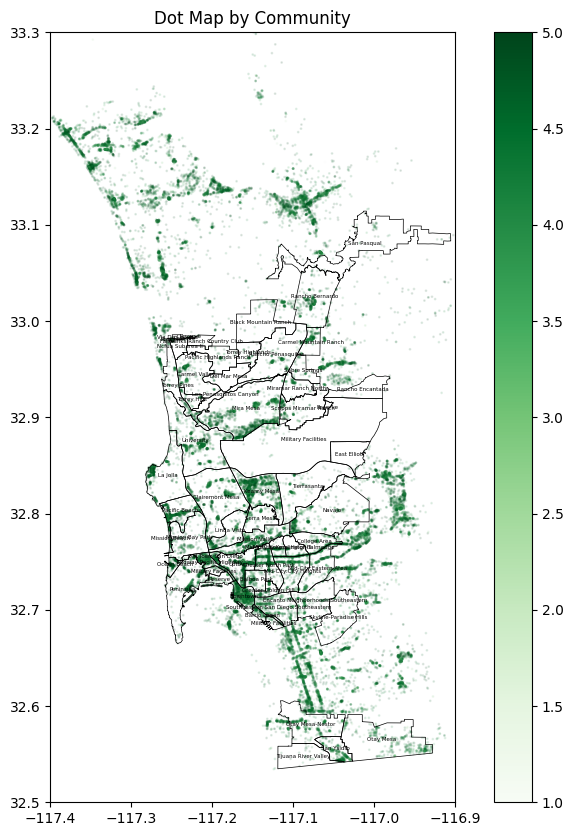

In [24]:
fig1, ax = plt.subplots(figsize=(10, 10))

bus_loc_plot = business_location_gdf.plot(ax=ax,
                                          column='avg_rating',
                                          markersize=1, 
                                          legend =True, 
                                          alpha=0.1,
                                          cmap = 'Greens')# color='purple'


communities_gdf.plot(color = 'none', 
                     ax=ax, 
                     edgecolor='black',
                     linewidth=0.5)#, norm=norm)

bus_loc_plot.set_xlim(-117.4,-116.9)
bus_loc_plot.set_ylim(32.5,33.3)


for x, y, label in zip(communities_gdf.geometry.centroid.x,
                      communities_gdf.geometry.centroid.y,
                      communities_gdf['community']):

        ax.text(x, y, label, fontsize=4, ha='center', va='center')

ax.set_title('Dot Map by Community')

plt.show()



/tmp/ipykernel_320/4135936266.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(sd_cities_boundaries_gdf.geometry.centroid.x,
/tmp/ipykernel_320/4135936266.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sd_cities_boundaries_gdf.geometry.centroid.y,


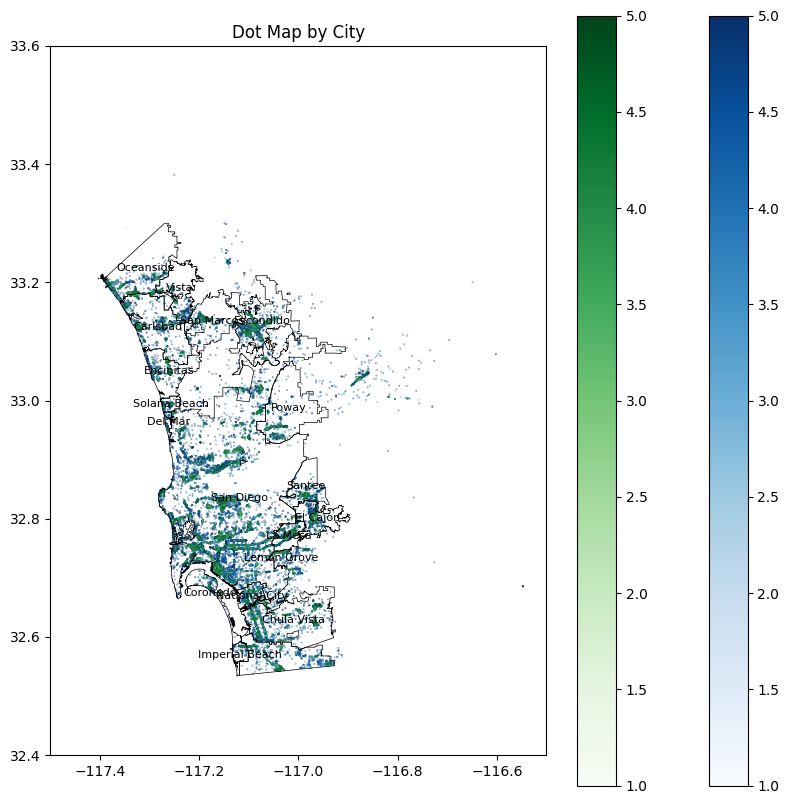

In [48]:
fig2, ax2 = plt.subplots(figsize=(10, 10))
# bus_loc_cities_plot = business_location_gdf.plot(ax=ax2, color='purple',markersize=1, alpha=0.1)

bus_loc_cities_plot = business_location_gdf[business_location_gdf['franchise']=="INDEPENDENT"].plot(ax=ax2,
                                          column='avg_rating',
                                          markersize=0.05, 
                                          legend =True, 
                                          alpha=1,
                                          cmap = 'Blues')# color='purple'

business_location_gdf[business_location_gdf['franchise']=="FRANCHISE"].plot(ax=ax2,
                                          column='avg_rating',
                                          markersize=0.05, 
                                          legend =True, 
                                          alpha=1,
                                          cmap = 'Greens')# color='purple'


sd_cities_boundaries_gdf.plot(color = 'none', ax=ax2, edgecolor='black', linewidth=0.5)#, norm=norm)

bus_loc_cities_plot.set_xlim(-117.5,-116.5)
bus_loc_cities_plot.set_ylim(32.4,33.6)


for x, y, label in zip(sd_cities_boundaries_gdf.geometry.centroid.x,
                      sd_cities_boundaries_gdf.geometry.centroid.y,
                      sd_cities_boundaries_gdf['City']):

        ax2.text(x, y, label, fontsize=8, ha='center', va='center')

ax2.set_title('Dot Map by City')

plt.show()



In [52]:
# Simple machine learning to predict avg_rating from lat lon



franchise_mapping = {'FRANCHISE': 1, 'INDEPENDENT': 0}
business_location_df['franchise_bool'] = business_location_df['franchise'].map(franchise_mapping)
X = business_location_df.dropna()[['latitude', 'longitude','franchise_bool']]
y = business_location_df.dropna()['avg_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.39283005495765577
R-squared: 0.044174848413208845


In [53]:
polynomial_regressor = Pipeline([('poly_features', PolynomialFeatures(degree=2)),
                                 ('linear_regression', LinearRegression())])

polynomial_regressor.fit(X_train, y_train)
y_poly = polynomial_regressor.predict(X_test)

mse_poly = mean_squared_error(y_test, y_poly)
r2_poly = r2_score(y_test, y_poly)
print(f"Mean Squared Error: {mse_poly}")
print(f"R-squared: {r2_poly}")

Mean Squared Error: 0.39209532042541756
R-squared: 0.045962587759497575


Predicted classes: [0. 0. 0. ... 0. 0. 0.]
Probabilities of class 1: [0.1893497  0.19432369 0.26365796 ... 0.25724771 0.14534302 0.16189581]
Accuracy: 0.7688295165394402
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.98      0.87      6113
         1.0       0.30      0.03      0.05      1747

    accuracy                           0.77      7860
   macro avg       0.54      0.50      0.46      7860
weighted avg       0.67      0.77      0.69      7860



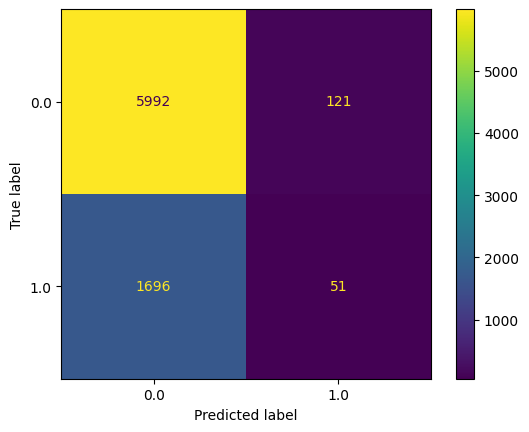

In [64]:

model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])


Xf = business_location_df.dropna()[['latitude', 'longitude','avg_rating']]#,'zip','blockgroup']]
yf = business_location_df.dropna()['franchise_bool']

Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.2, random_state=42)


model.fit(Xf_train, yf_train)

# Predict the class label (0 or 1)
yf_logist = model.predict(Xf_test)
print(f"Predicted classes: {yf_logist}")

# Predict the probability of belonging to class 1
yf_probabilities = model.predict_proba(Xf_test)[:, 1] #
print(f"Probabilities of class 1: {yf_probabilities}")




print(f"Accuracy: {accuracy_score(yf_test, yf_logist)}")
print("Classification Report:")
print(classification_report(yf_test, yf_logist))

cm_logist = confusion_matrix(yf_test, yf_logist)


disp = ConfusionMatrixDisplay.from_estimator(model, Xf_test, yf_test)
